# Impersonation Scam Prediction
## Members
1) Heng Jing Han (1003590)

2) Jeremy Chew (1003301)

3) Lim Yang Zhi (1003458)

4) Tiang Pei Yuan (1003323)

5) Yu Wenling (1003793)

## Introduction
Impersonation scams are online scams where malicious users impersonate other users on sites such as social media in order to target their family or close ones. In this project, we aims to predict potential victims of these types of scams, assuming that the impersonator is already known.

In this notebook, we initialise and train the model.

## Google Colab initialisation
Mount the drive and navigate to the correct directory.

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir("drive/My Drive/DL BIG/final-code")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

data		  graph.py    models	    __pycache__
deployment.ipynb  main.ipynb  network.html  requirements.txt


## Import libraries
The full list of requirements can be found in `requirements.txt`, and can be installed through `pip` using `pip install -r requirements.txt`.

In [ ]:
!pip install -r requirements.txt --quiet

In [ ]:
# required libraries
import networkx as nx
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random

# project-specific functions
import graph

## Set variables
Set model training variables, as well as data-specific variables. Also, set the seed for reproducibility.

In [ ]:
# training variables
epochs = 100
lr = 0.01
momentum = 0.9

# data variables
num_scammers = 2
max_hop = 3

# set seeds for reproducibility
seed = 100
random.seed(seed)

# check if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Build graph object, generate data points
See `graph.py` for more details on the specific functions.

In [ ]:
# read data and build graph object
G, features = graph.read_data('data/3980_edited.edges', 'data/3980_edited.feat')

# set which features to use (we only use feature 19, which is the anonymised gender)
features = [19]

# get the data points
X, y = graph.generate_samples(G, features, num_scammers=num_scammers, max_hop=max_hop)

# split data into train and test (we use a 80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# load adjacency matrix
A = nx.adjacency_matrix(G).todense()
A = torch.Tensor(A).to(device)

# get the input feature size
input_size = len(X_train[0][0])

## Initialise model
We try to account for imbalance within our generated dataset by weighting how `nn.CrossEntropyLoss` calculates the loss.

In [ ]:
# try to account for imbalance (only look within the training set)
num_pos = sum(sum(lbl) for lbl in y_train)
num_neg = len(G.nodes) * len(y_train) - num_pos
samples = [num_neg, num_pos]
wts = [1 - x / sum(samples) for x in samples]
print(wts)
weights = torch.Tensor(wts).to(device)

# create the model
model = graph.Net(A, input_size, 10, 2, device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimiser = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

[0.7698863636363636, 0.23011363636363635]


## Train the model
We print out the training loss every 10 epochs. We will also plot how the losses vary as training progresses. We also save the model every 10 epochs.

Epoch 10 of 100
	Loss: 0.6591846093535423
Epoch 20 of 100
	Loss: 0.6551462300121784
Epoch 30 of 100
	Loss: 0.6483254827558994
Epoch 40 of 100
	Loss: 0.6473249044269324
Epoch 50 of 100
	Loss: 0.6352627895772457
Epoch 60 of 100
	Loss: 0.6306695163249969
Epoch 70 of 100
	Loss: 0.6261236716061831
Epoch 80 of 100
	Loss: 0.6253911044448615
Epoch 90 of 100
	Loss: 0.6254930097609759
Epoch 100 of 100
	Loss: 0.6228230431675911


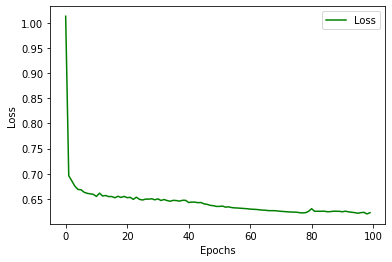

In [ ]:
# collect losses
losses = []

# train the model
for epoch in range(epochs):
    tl_loss = 0
    tl = 0
    for X, y in zip(X_train, y_train):
        # move X, y to device
        X = torch.Tensor(X).to(device)
        y = torch.Tensor(y).to(device).long()

        # forward pass
        optimiser.zero_grad()
        out = model(X)

        # backprop
        loss = criterion(out, y)
        loss.backward()
        optimiser.step()

        tl_loss += loss.item()
        tl += 1

    # show loss and save the model in case it crash during training
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1} of {epochs}\n\tLoss: {tl_loss / tl}')      
        torch.save(model.state_dict(), f'models/train/model_{epoch + 1}.pt')

    losses.append(tl_loss / tl)
    
# plot the training loss
plt.plot(range(epochs), losses, 'g', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Test the model
For our metrics, we calculate the number of true positives, false positives, true negatives, and false negatives.

In [ ]:
# test the model
TP = TN = FP = FN = 0
model.eval()
for X, y in zip(X_test, y_test):
    # move X to device
    X = torch.Tensor(X).to(device)

    # get output, convert to actual labels
    out = model(X)
    out = torch.argmax(out, dim=1)

    # calculate metrics
    for pred, actual in zip(out.cpu().tolist(), y):
        if pred == actual == 0:
            TN += 1
        elif pred == actual == 1:
            TP += 1
        elif pred == 1:
            FP += 1
        else:
            FN += 1


print(f'TP: {TP}. FP: {FP}. TN: {TN}. FN: {FN}.')
print(f'Accuracy: {(TP + TN) / (TP + TN + FP + FN)}')

TP: 488. FP: 71. TN: 119. FN: 202.
Accuracy: 0.6897727272727273


## Visualisations
We show how the network graph looks like. We also show how our model performs on a random sample from our test set.

In [ ]:
from pyvis import network as net
from dimcli.utils.networkviz import *

# show the network graph
g = NetworkViz(notebook=True)

# convert the networkx graph to one supported by pyvis
for node in G.nodes:
    g.add_node(node, size=8)

for (f_node, t_node) in G.edges:
    g.add_edge(f_node, t_node)

# show the graph
g.show("network.html")

In [ ]:
# choose a random sample
X, y = random.choice(list(zip(X_test, y_test)))

# run this through our model
X = torch.Tensor(X).to(device)
out = torch.argmax(model(X), dim=1)

# colour the nodes accordingly
# if it was a victim, and was predicted as such (TP)      : yellow
# if it was not a victim, and was predicted as such (TN)  : cyan
# if it was not a victim, but was predicted as one (FP)   : blue
# if it was a victim, but was not predicted as one (FN)   : red
# if it was a scammer                                     : black

yellow = '#FFD700'
cyan = '#51F59D'
blue = '#3220F5'
red = '#F53F2C'
black = '#000000'

for i, node in enumerate(G.nodes):
    pred = out.cpu().tolist()[i]
    actual = y[i]
    
    if X[i][0] == 1:
        # scammer
        g.nodes[i]['color'] = black
    elif pred == actual == 0:
        # TN
        g.nodes[i]['color'] = cyan
    elif pred == actual == 1:
        # TP
        g.nodes[i]['color'] = yellow
    elif pred == 1:
        # FP
        g.nodes[i]['color'] = blue
    else:
        # FN
        g.nodes[i]['color'] = red

# show the graph
g.show("network.html")

## Model saving
Save the model so that we can use it for later.

In [ ]:
torch.save(model.state_dict(), f'models/model_final.pt')